# Compare the Training Sets of Allsoteric Site Prediction Tools

In [1]:
import collections
import gzip
import json
import tqdm
import matplotlib_venn
import pandas as pd
import requests
from IPython.display import display


def uniprot_from_pdb(pdb_ids):
    pdb_ids_string = '", "'.join(pdb_ids)

    body = 'query {entries(entry_ids: ["' + pdb_ids_string + '"])' + """
      {
        rcsb_id
        polymer_entities {
          uniprots {
            rcsb_id
          }
        }
      }
    }
    """
    response = requests.post(url='https://data.rcsb.org/graphql', json={"query": body})
    response_data = response.json()

    id_mapping = []
    for record in response_data['data']['entries']:
        rcsb_id = record['rcsb_id']
        uniprot_ids = set()
        for entity in record['polymer_entities']:
            if entity['uniprots']:
                uniprot_ids.add(entity['uniprots'][0]['rcsb_id'])
        id_mapping.append([rcsb_id, uniprot_ids])
        
    return pd.DataFrame(id_mapping, columns=['pdb_id', 'uniprot_id_from_pdb'])


def uniprot_pdb_fix(df):
    df_copy = df[['pdb_id', 'uniprot_id']].drop_duplicates().copy()

    # Get the UniProt IDs of the chains in the proteins from PDB website
    df_pdb = uniprot_from_pdb(df_copy['pdb_id'])
    
    # Count the number of UniProt IDs obtained from PDB website for each PDB ID
    df_pdb['num_uniprot'] = df_pdb['uniprot_id_from_pdb'].apply(len)
    
    df_merged = df_copy.merge(df_pdb, how='left')

    # Check if the UniProt ID in ASD is present in the UniProt IDs obtained from PDB website
    df_merged['present'] = df_merged.apply(lambda x: x['uniprot_id'] in x['uniprot_id_from_pdb'], axis=1)
    df_present = df_merged.loc[df_merged['present'], ['pdb_id', 'uniprot_id']]

    # UniProt IDs absent in the ASD but has only one UniProt ID downloaded from PDB
    df_absent_single = df_merged[~df_merged['present'] & (df_merged['num_uniprot'] == 1)].copy()
    print("PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB")
    display(df_absent_single)

    # Place the only one UniProt ID from the set in Uniprot ID column to pdb_uniprot column
    if not df_absent_single.empty:
        df_absent_single['uniprot_id'] = df_absent_single.apply(lambda x: next(iter(x['uniprot_id_from_pdb'])), axis=1)
    df_absent_single = df_absent_single[['pdb_id', 'uniprot_id']]
    
    df_absent_multiple = df_merged[~df_merged['present'] & (df_merged['num_uniprot'] != 1)]
    print("PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB")
    display(df_absent_multiple)
    
    df_absent_multiple_expanded = df_absent_multiple.explode('uniprot_id_from_pdb')
    df_absent_multiple_expanded = df_absent_multiple_expanded[['pdb_id', 'uniprot_id_from_pdb']]
    df_absent_multiple_expanded.rename(columns={'uniprot_id_from_pdb': 'uniprot_id'}, inplace=True)

    df_output = pd.concat([df_present, df_absent_single, df_absent_multiple_expanded])
    return df_output.sort_values(['pdb_id', 'uniprot_id']).reset_index(drop=True)


def replace_obsolete_pdbs(pdb_set, obsolete_pdbs):
    for pdb in pdb_set & set(obsolete_pdbs.keys()):
        pdb_set.remove(pdb)
        pdb_set.add(obsolete_pdbs[pdb])
        print(f'PDB ID {pdb} has been superseded by {obsolete_pdbs[pdb]}')

## Fix Obsolete PDB Entries

The list of obsolete PDB IDs are downloaded from the World Wide Protein Data Bank

While most obsolete PDB IDs have been superseded by only one PDB ID. There exists PDB IDs superseded by multiple PDB IDs. For such cases we select the last PDB ID in the list assuming that it will be the latest one. Obsolete entries without a superseded PDB ID are be removed. 

However, in the ASD dataframe (`df_asd`) each obsolete PDB ID had only one superseded PDB ID. 

In [2]:
response = requests.get('https://files.wwpdb.org/pub/pdb/holdings/all_removed_entries.json.gz')

obsolete_pdbs = {}
for pdb_id, value in json.loads(gzip.decompress(response.content)).items():
    if 'superseded_by' in value:
        # Select the last element in the list of superseded PDB IDs
        obsolete_pdbs[pdb_id] = value['superseded_by'][-1] 
    else:
        obsolete_pdbs[pdb_id] = []

print('Number of Obsolete PDB IDs:', len(obsolete_pdbs))

Number of Obsolete PDB IDs: 5917


## ASD

In [3]:
# df_asd = pd.read_table('../data/ASD_Release_202309_AS.txt')
df_asd = pd.read_csv('../output/ASD_Release_202306.csv')

# Replace the obsolete PDB IDs with the latest PDB IDs
df_asd.replace({'allosteric_pdb': obsolete_pdbs}, inplace=True)

# Get the set of PDB IDs
asd_pdb_set = set(df_asd['allosteric_pdb'])

# Get the set of UniProt Accession Numbers
asd_uniprot_set = set(df_asd['pdb_uniprot'])

## ALLO

In [4]:
# Open the training and test set tab separated files from Allopred GitHub repo
# df_allo_AO = pd.read_table('https://raw.githubusercontent.com/fibonaccirabbits/allo/master/data/ao.tsv')
# df_allo_AO['PDB_ID'] = df_allo_AO['name'].str.extract(r'_([0-9A-Z]{4})_')

df_allo_APLC = pd.read_table('https://raw.githubusercontent.com/fibonaccirabbits/allo/master/data/aplc.tsv')
df_allo_APLC['pdb_id'] = df_allo_APLC['name'].str.extract(r'_([0-9A-Z]{4})_')

df_allo_pdbs = df_allo_APLC[['pdb_id']].drop_duplicates().copy()

# Replace obsolete PDB IDs
df_allo_pdbs.replace({'pdb_id': obsolete_pdbs}, inplace=True)

df_allo_pdb_uniprot = df_allo_pdbs.merge(df_asd, how='left', left_on='pdb_id', right_on='allosteric_pdb').drop_duplicates()
df_allo_pdb_uniprot = df_allo_pdb_uniprot[['pdb_id', 'pdb_uniprot']].drop_duplicates().rename(columns={'pdb_uniprot': 'uniprot_id'})

# Fix UniProt IDs by fetching them from PDB and resolving discrepancies
df_allo = uniprot_pdb_fix(df_allo_pdb_uniprot)

# Get the set of PDB IDs
allo_pdb_set = set(df_allo['pdb_id'])

# Get the set of UniProt Accession Numbers
allo_uniprot_set = set(df_allo['uniprot_id'])

print('Rows =', len(df_allo_pdbs), ' PDB IDs =', len(allo_pdb_set), ' UniProt ACs =', len(allo_uniprot_set))

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present


Rows = 95  PDB IDs = 95  UniProt ACs = 85


In [5]:
allo_pdb_set = set(df_allo_APLC['pdb_id'])
replace_obsolete_pdbs(allo_pdb_set, obsolete_pdbs)

allo_pdb_not_in_asd = allo_pdb_set - asd_pdb_set
uniprot_from_pdb(allo_pdb_not_in_asd)

PDB ID 3MW9 has been superseded by 6DHM


,pdb_id,uniprot_id_from_pdb


In [6]:
df_allo_pdb_uniprot[df_allo_pdb_uniprot['pdb_id'].duplicated(keep=False)]

,pdb_id,uniprot_id
85,2D5X,P01958
86,2D5X,P02062


In [7]:
df_allo

,pdb_id,uniprot_id
0,11BG,P00669
1,1B86,P68871
2,1CE8,P00968
3,1DKU,P14193
4,1EM6,P06737
...,...,...
93,4MBS,P51681
94,4NBN,P55212
95,4NLD,Q9WMX2
96,4P3H,Q2HRB6


## Allosite and PASSER Training Set (90 proteins from ASD)
Manually Extracted from Supporting Information of "PASSer: Prediction of Allosteric Sites Server" (https://dx.doi.org/10.1088/2632-2153/abe6d6) and "Allosite: a method for predicting allosteric sites" (https://doi.org/10.1093/bioinformatics/btt399)

In [8]:
allosite_pdb_set = {
    '1AO0', '1CE8', '1COZ', '1DB1', '1DD7', '1EFA', '1EGY', '1ESM', '1FAP', '1FTA',
    '1HAK', '1I7S', '1KP8', '1LDN', '1LTH', '1PEQ', '1PFK', '1PJ3', '1QTI', '1QW7',
    '1RD4', '1RX2', '1S9J', '1SHJ', '1T49', '1TUG', '1V4S', '1W25', '1W96', '1X88',
    '1XJE', '1XLS', '1XTU', '1Z8D', '1ZDS', '2AL4', '2BND', '2BU2', '2C2B', '2CLH',
    '2D5Z', '2EWN', '2GS7', '2I80', '2OI2', '2POC', '2PUC', '2Q5O', '2QF7', '2R1R',
    '2V92', '2VGI', '2X1L', '2XO8', '2YC3', '2ZMF', '3AO1', '3BEO', '3CQD', '3EPS',
    '3F3V', '3F6G', '3FIG', '3FZY', '3GCP', '3GR4', '3GVU', '3H30', '3HO8', '3HV8',
    '3I0R', '3IAD', '3IDB', '3IJG', '3IRH', '3IYD', '3MK6', '3MKS', '3NJQ', '3O2M',
    '3OS8', '3PEE', '3PJG', '3PTZ', '3QEL', '3RZ3', '3UO9', '3ZLK', '4AVB', '4B9Q',
}

In [9]:
replace_obsolete_pdbs(allosite_pdb_set, obsolete_pdbs)

In [10]:
allosite_pdb_not_in_asd = allosite_pdb_set - asd_pdb_set
uniprot_from_pdb(allosite_pdb_not_in_asd)

,pdb_id,uniprot_id_from_pdb
0,3GCP,{Q16539}
1,2QF7,{Q2K340}
2,1DB1,{P11473}
3,2GS7,{P00533}
4,1XLS,"{P19793, O35627, Q9WUI9}"
5,2X1L,{A0R3E2}
6,2BND,{P0A7E9}
7,3OS8,{P03372}
8,1ESM,{P0A6I3}
9,1QTI,{P04058}


In [11]:
df_allosite_pdbs = pd.DataFrame(allosite_pdb_set, columns=['pdb_id'])
df_allosite_pdb_uniprot = df_allosite_pdbs.merge(df_asd, how='left', left_on='pdb_id', right_on='allosteric_pdb').drop_duplicates()
df_allosite_pdb_uniprot = df_allosite_pdb_uniprot[['pdb_id', 'pdb_uniprot']].drop_duplicates().rename(columns={'pdb_uniprot': 'uniprot_id'})
df_allosite_pdb_uniprot

,pdb_id,uniprot_id
0,3H30,P68400
1,1AO0,P00497
2,3GCP,NaN
3,3RZ3,P49427
4,3GR4,P14618
...,...,...
87,2EWN,P06709
88,3NJQ,P88911
89,1XLS,NaN
90,3F3V,P00523


In [12]:
df_allosite = uniprot_pdb_fix(df_allosite_pdb_uniprot)

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
2,3GCP,NaN,{Q16539},1,False
13,2QF7,NaN,{Q2K340},1,False
14,2BND,NaN,{P0A7E9},1,False
15,2X1L,NaN,{A0R3E2},1,False
22,1RX2,NaN,{P0ABQ4},1,False
33,1DB1,NaN,{P11473},1,False
37,1ESM,NaN,{P0A6I3},1,False
51,3FIG,NaN,{P9WQB3},1,False
53,1COZ,NaN,{P27623},1,False
56,2GS7,NaN,{P00533},1,False


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
20,3IDB,NaN,"{P05132, P12369}",2,False
87,1XLS,NaN,"{P19793, O35627, Q9WUI9}",3,False


In [13]:
# Get the set of PDB IDs
allosite_pdb_set = set(df_allosite['pdb_id'])

# Get the set of UniProt Accession Numbers
allosite_uniprot_set = set(df_allosite['uniprot_id'])

print('Rows =', len(df_allosite_pdbs['pdb_id']), ' PDB IDs =', len(allosite_pdb_set), ' UniProt ACs =', len(allosite_uniprot_set))

Rows = 90  PDB IDs = 90  UniProt ACs = 93


## AllositePro Training Set (ASBench Core-Diversity Set)

In [14]:
df_allositepro_data = pd.read_excel('../data/ASBench_Core_Diversity_Set.xls')

print(set(df_allositepro_data['PDB ID']) - asd_pdb_set)

# Replace obsolete PDB IDs
df_allositepro_data.replace({'PDB ID': obsolete_pdbs}, inplace=True)

print(set(df_allositepro_data['PDB ID']) - asd_pdb_set)

{'3MW9'}
set()


In [15]:
df_allositepro = uniprot_pdb_fix(df_allositepro_data[['PDB ID', 'Uniprot ID']].rename(columns={'PDB ID': 'pdb_id', 'Uniprot ID': 'uniprot_id'}))

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
50,4IO8,P08107,{P0DMV8},1,False
52,3LSW,Q9Z2W9,{P19492},1,False
72,4P3H,O36607,{Q2HRB6},1,False
77,1QP0,P9WJJ7,{P0ACP7},1,False
96,4OO9,P00720,{P41594},1,False
101,3LAJ,P9WPY8,{P9WPY9},1,False
127,3HO8,Q99UY8,{A0A0H3JRU9},1,False
129,2RDE,A5F1K1,{A0A0H3ADR8},1,False
130,3PJG,C4XAX5,{A0A0J9WZA6},1,False
134,4MBS,P00268,{P51681},1,False


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present


In [16]:
# Get the set of PDB IDs
allositepro_pdb_set = set(df_allositepro['pdb_id'])

# Get the set of UniProt Accession Numbers
allositepro_uniprot_set = set(df_allositepro['uniprot_id'])

print('Rows =', len(df_allositepro_data['PDB ID']), ' PDB IDs =', len(allositepro_pdb_set), ' UniProt ACs =', len(allositepro_uniprot_set))

Rows = 147  PDB IDs = 143  UniProt ACs = 127


## AlloReverse

In [17]:
df_alloreverse_training = pd.read_csv('../data/AlloReverse_Training_Set.csv')

df_alloreverse_training['pdb_id'] = df_alloreverse_training['PDB ID (PDB:Chain(s)) '].dropna().str.extract('([0-9A-Z]{4}):')
df_alloreverse_training['uniprot_id'] = df_alloreverse_training['Uniprot ID '].str.replace(' ', '')
df_alloreverse_training = df_alloreverse_training[['uniprot_id', 'pdb_id']].dropna(subset='pdb_id')

In [18]:
df_alloreverse_test = pd.read_csv('../data/AlloReverse_Test_Set.csv')

df_alloreverse_test['pdb_id'] = df_alloreverse_test['PDB ID (PDB:Chain(s)) '].dropna().str.extract('([0-9A-Z]{4}):')
df_alloreverse_test['uniprot_id'] = df_alloreverse_test['Uniprot ID '].str.replace(' ', '')
df_alloreverse_test = df_alloreverse_test[['uniprot_id', 'pdb_id']].dropna(subset='pdb_id')

In [19]:
df_alloreverse_training = uniprot_pdb_fix(df_alloreverse_training)

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
2,1FBP,P09467,{P00636},1,False
3,1G2V,O27819,{Q9HU22},1,False
39,2XCS,P66937,{Q99XG5},1,False
60,3U1I,Q91H74,{Q5UB51},1,False
65,4BDZ,P12497,{P14350},1,False
88,5AFJ,P36544,{P58154},1,False
102,4PA0,P12883,{P42212},1,False
119,6KQI,P21554,{Q9V2J8},1,False


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
32,2PBK,O36607,{},0,False
75,4KH0,N.A.,{},0,False
92,7DD5,N.A.,{},0,False
106,5OUG,N.A.,{},0,False


In [20]:
df_alloreverse_training.loc[df_alloreverse_training['pdb_id'] == '2PBK', 'uniprot_id'] = 'Q2HRB6'
df_alloreverse_training.loc[df_alloreverse_training['pdb_id'] == '7DD5', 'uniprot_id'] = 'A0A8I3AZV5'

display(df_alloreverse_training[df_alloreverse_training.isna().any(axis=1)])
df_alloreverse_training.dropna(inplace=True)
display(df_alloreverse_training[df_alloreverse_training.isna().any(axis=1)])

,pdb_id,uniprot_id
72,4KH0,NaN
103,5OUG,NaN


,pdb_id,uniprot_id


In [21]:
df_alloreverse_test = uniprot_pdb_fix(df_alloreverse_test)

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
19,2JFZ,P22634,{Q9ZLT0},1,False
22,2SKC,P06737,{P00489},1,False
24,2YQS,Q386Q8,{O74933},1,False
36,5IM3,P21524,{Q9I4I1},1,False
43,4XNW,P47900,{P00268},1,False


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
8,1I7Q,P00898,"{P00900, P00897}",2,False
41,4R1R,P23921,"{P00452, P69924}",2,False


In [22]:
df_test = pd.read_csv('../output/Test_Set.csv')

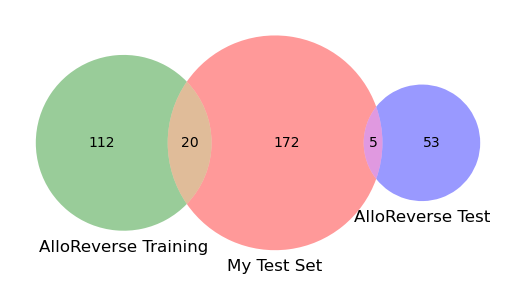

In [23]:
matplotlib_venn.venn3([set(df_test['allosteric_pdb']), set(df_alloreverse_training['pdb_id']), set(df_alloreverse_test['pdb_id'])], ['My Test Set', 'AlloReverse Training', 'AlloReverse Test']);

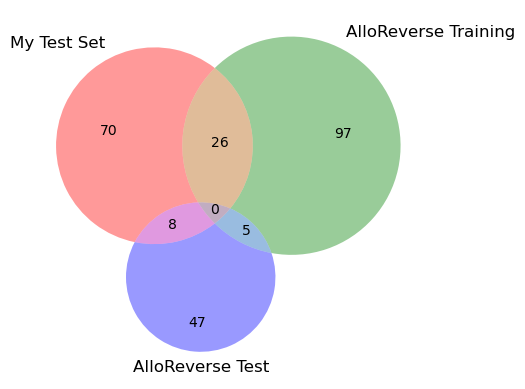

In [24]:
matplotlib_venn.venn3([set(df_test['pdb_uniprot']), set(df_alloreverse_training['uniprot_id']), set(df_alloreverse_test['uniprot_id'])], ['My Test Set', 'AlloReverse Training', 'AlloReverse Test']);

## Allopred Training Set

In [25]:
# Open the training and test set tab separated files from Allopred GitHub repo
df_allopred_training = pd.read_table('https://github.com/jgreener64/allopred/raw/25037ad6cff312ee2886f35ea39d5a403167b7cb/dataset/training_set.tsv')
df_allopred_test = pd.read_table('https://github.com/jgreener64/allopred/raw/25037ad6cff312ee2886f35ea39d5a403167b7cb/dataset/test_set.tsv')
df_allopred_all = pd.concat([df_allopred_training, df_allopred_test]).reset_index(drop=True)

# Replace obsolete PDB IDs
df_allopred_all.replace({'PDB ID': obsolete_pdbs}, inplace=True)

# Fix UniProt IDs by fetching them from PDB and resolving discrepancies
df_allopred = uniprot_pdb_fix(df_allopred_all[['PDB ID', 'UniProt ID']].rename(columns={'PDB ID': 'pdb_id', 'UniProt ID': 'uniprot_id'}))

# Get the set of PDB IDs
allopred_pdb_set = set(df_allopred['pdb_id'])

# Get the set of UniProt Accession Numbers
allopred_uniprot_set = set(df_allopred['uniprot_id'])

print('Rows =', len(df_allopred_all['PDB ID']), ' PDB IDs =', len(allopred_pdb_set), ' UniProt ACs =', len(allopred_uniprot_set))

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
1,2RDE,A5F1K1,{A0A0H3ADR8},1,False
2,3PJG,C4XAX5,{A0A0J9WZA6},1,False
5,4P3H,O36607,{Q2HRB6},1,False
11,4MBS,P00268,{P51681},1,False
18,4OO9,P00720,{P41594},1,False
31,4IO8,P08107,{P0DMV8},1,False
71,3HO8,Q99UY8,{A0A0H3JRU9},1,False
77,3LSW,Q9Z2W9,{P19492},1,False
105,1QP0,P9WJJ7,{P0ACP7},1,False
108,3LAJ,P9WPY8,{P9WPY9},1,False


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present


Rows = 119  PDB IDs = 119  UniProt ACs = 119


## PASSer (AutoML) and PASSERRank

The features of the 207 PDB srtuctures used to train PASSer's AutoML and learning to rank models are available at https://passer.smu.edu/static/allorank.zip

In [26]:
from zipfile import ZipFile
from io import BytesIO
import pickle

# # Get the PASSer (AutoML) and PASSerRank dataset
# response = requests.get('https://passer.smu.edu/static/allorank.zip')
# passer_dataset = ZipFile(BytesIO(response.content))
# passerrank_dataset_downloaded = pickle.load(passer_dataset.open('allorank/asd/features.pkl'))

# The file above is also provided locally at '../data/passerank_dataset/allorank/asd/features.pkl'
passerrank_dataset_downloaded = pickle.load(open('../data/passerank_dataset/allorank/asd/features.pkl', 'rb'))

The PDB IDs are not available in the datasets. In order to identify the PDB IDs the PasserRank dataset generation pipeline (https://github.com/smu-tao-group/PASSerRank) was run to obtain the features file `../data/passerank_dataset/asd_featurized/features.pkl`. The source code was modified to write the corresponding PDB IDs into `../data/passerank_dataset/asd_featurized/featurized_pdbs.txt`

In [27]:
import numpy as np

# Read the features file generated by PASSerRank dataset creation pipeline
passerrank_dataset_generated = pickle.load(open('../data/passerank_dataset/asd_featurized/features.pkl', 'rb'))

passerrank_generated_pdb_ids = [_.strip() for _ in open('../data/passerank_dataset/asd_featurized/featurized_pdbs.txt', 'r').readlines()]

# Ensure the lengths of the two arrays are same
print('Are the number of items in the generated dataset same as the number of PDB IDs?')
print(len(passerrank_dataset_generated) == len(passerrank_generated_pdb_ids))

passerrank_downloaded = [np.delete(np.array(_), 6, 1) for _ in passerrank_dataset_downloaded]
passerrank_generated = [np.delete(np.array(_), 6, 1) for _ in passerrank_dataset_generated]

Are the number of items in the generated dataset same as the number of PDB IDs?
True


Match the features in the downloaded dataset with those from the generated dataset and save the corresponding PDB IDs

In [28]:
passer_pdb_set = set()
for i, protein1 in enumerate(passerrank_downloaded):
    found = False
    for j, protein2 in enumerate(passerrank_generated):
        if np.array_equal(protein1, protein2):
            passer_pdb_set.add(passerrank_generated_pdb_ids[j])
            found = True
    if not found:
        print(f'PDB ID for the feature at index {i} could not be identified.')
print()
print(passer_pdb_set)

PDB ID for the feature at index 185 could not be identified.

{'3ZFZ', '3F1O', '4UUU', '3H30', '3RZ3', '4BQH', '4OYI', '1NH8', '3NF7', '2I80', '4MBS', '3THO', '3MWB', '4I89', '3DBA', '1YGC', '2A68', '3ETL', '3ATH', '3MJX', '1XJG', '3AUY', '3ZM9', '3OF1', '4BXH', '1IKW', '3PDT', '3LAP', '2PIO', '1CE8', '1T48', '2Q5O', '3TUV', '2P2N', '3BRK', '4EAJ', '2VPR', '4CEV', '3PTZ', '4OR2', '1JLR', '3FUD', '2BBH', '1GPH', '3L76', '1I6K', '2ORO', '3CMW', '1GFZ', '2O8B', '2FSZ', '2VJY', '4LUC', '1PFK', '1PEQ', '3QEM', '2QMX', '1ZDQ', '2JFZ', '4A7A', '4FC0', '2BTY', '1UXU', '3PA8', '4OP0', '3S8A', '1QW7', '1MC0', '1HK8', '1FCJ', '2HVW', '1O0S', '4HNN', '4Q0A', '3C35', '1VM1', '2JFN', '4TQC', '4TVG', '3MZH', '1W0F', '3OC1', '1UM8', '1W96', '3KJF', '4JAF', '1VST', '2QB4', '4AQH', '2H08', '1G9V', '3LA3', '2ZMF', '1TUG', '3ZG1', '4P3H', '3E6C', '2VD4', '3KH5', '3PG9', '2UYI', '1I1Q', '1K7E', '3N1V', '1BJ4', '1FX2', '3BEO', '3MKS', '2I7P', '4NIR', '3KC1', '2JC9', '3D2P', '2YC5', '1EGY', '4TPT', '3JVS', '

In [29]:
print(len(passerrank_downloaded) - len(passer_pdb_set), 'PDB ID could not be identified', )

1 PDB ID could not be identified


In [30]:
# passer_pdb_set = {
#     '3F1O', '4A7A', '1K7E', '3ETQ', '2YC5', '4AVB', '1ZDQ', '1V4S', '2BU8',
#     '1IKW', '4M0Z', '3OC1', '1I6K', '4B76', '2ZMF', '3BEO', '3NAX', '1BJ4',
#     '3F78', '2UYI', '1O0S', '2Q5O', '4OYI', '2I80', '4KE5', '1VPW', '2HA4',
#     '1MSV', '1FX2', '1T5A', '1ZRC', '4OR2', '4RUT', '3CMW', '3KC1', '3PP1',
#     '4I1R', '4EAJ', '3E6C', '3ATH', '3PTZ', '4M1P', '3PDT', '3D2F', '3LA3',
#     '1CZA', '1EGY', '4LUC', '1SHJ', '3E3I', '3N1V', '4AQH', '1G0R', '3MKS',
#     '1EFA', '1T48', '3OF1', '1XJG', '3DBA', '2PIO', '1CE8', '4FXY', '1GFZ',
#     '2O8B', '3MJX', '4I4F', '3MZH', '1SG8', '3EEB', '1UXU', '3AUY', '3NF7',
#     '4BQH', '2QB4', '1TBF', '1YGC', '3BRK', '2C13', '3PNA', '2BXA', '4FC0',
#     '3RZ3', '3C35', '4UUU', '4TVG', '3VP2', '2EWN', '2ORO', '3LAP', '4CEV',
#     '1TUG', '1UM8', '1W96', '4B9Q', '3QAK', '3IAD', '3ZFZ', '2DEW', '1MC0',
#     '3SMQ', '3S8A', '2R1R', '4I89', '2I7P', '2JFZ', '1GPH', '3EPS', '1PEQ',
#     '1FCJ', '2VVT', '2BTY', '4EJN', '3PA8', '3FUD', '2VJY', '3ETL', '4GQQ',
#     '4TPT', '3H30', '2HVW', '4QSK', '2RDE', '1PFK', '2VPR', '1HAK', '4P3H',
#     '1JLR', '4Q9M', '2FSZ', '2H08', '4BXH', '1W0F', '4MBS', '1M8P', '1XMV',
#     '4EU0', '3JVS', '4DFZ', '3THO', '3ZG1', '2P2N', '1F2U', '4BNY', '2JC9',
#     '3ETD', '3HL8', '4JA8', '4P9D', '2PUV', '1YXD', '4NIR', '2ONB', '2VD4',
#     '1R1V', '4TQC', '2CDQ', '4OP0', '3KJF', '4C7B', '2XTA', '1QW7', '3PG9',
#     '3HV8', '2VD3', '1G9V', '4A7W', '2QMX', '1NSG', '4JAF', '4OHF', '1FS5',
#     '3PJG', '3TUV', '3L76', '4QPL', '4Q0A', '1Z2L', '3F6H', '1I1Q', '2PA3',
#     '3NUD', '2BBH', '4QFX', '4HNN', '3QEM', '3IJG', '3D2P', '4KZT', '3ZM9',
#     '1XXB', '2A68', '1CSM', '1VEA', '11BG', '2DJZ', '3KH5', '1T34', '1VM1',
#     '1OG0', '1NH8', '1VST', '2JFN', '1HK8', '3MWB', '3UMO', '3K8S'}

In [31]:
replace_obsolete_pdbs(passer_pdb_set, obsolete_pdbs)

In [32]:
passer_pdb_not_in_asd = passer_pdb_set - set(df_asd.loc[df_asd['allosteric_pdb'].isin(passer_pdb_set), 'allosteric_pdb'])
uniprot_from_pdb(passer_pdb_not_in_asd)

,pdb_id,uniprot_id_from_pdb
0,4QSK,{}


In [33]:
df_passer_pdbs = pd.DataFrame(passer_pdb_set, columns=['pdb_id'])
df_passer_pdb_uniprot = df_passer_pdbs.merge(df_asd, how='left', left_on='pdb_id', right_on='allosteric_pdb').drop_duplicates()
df_passer_pdb_uniprot = df_passer_pdb_uniprot[['pdb_id', 'pdb_uniprot']].drop_duplicates().rename(columns={'pdb_uniprot': 'uniprot_id'})
df_passer_pdb_uniprot

,pdb_id,uniprot_id
0,3ZFZ,A0A0H3JPA5
2,3F1O,Q99814
3,4UUU,P35520
4,3H30,P68400
5,3RZ3,P49427
...,...,...
222,1EFA,P03023
223,4KE5,P26663
225,2EWN,P06709
226,1YXD,P0A6L2


In [34]:
df_passer = uniprot_pdb_fix(df_passer_pdb_uniprot)

PDB IDs Absent from ASD with Single UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present


PDB IDs Absent from ASD with Multiple UniProt ID fetched from the PDB


,pdb_id,uniprot_id,uniprot_id_from_pdb,num_uniprot,present
166,4QSK,NaN,{},0,False


In [35]:
# Get the set of PDB IDs
passer_pdb_set = set(df_passer['pdb_id'])

# Get the set of UniProt Accession Numbers
passer_uniprot_set = set(df_passer['uniprot_id'])

print('Rows =', len(df_allositepro_data['PDB ID']), ' PDB IDs =', len(allositepro_pdb_set), ' UniProt ACs =', len(allositepro_uniprot_set))

Rows = 147  PDB IDs = 143  UniProt ACs = 127


## Venn Diagrams

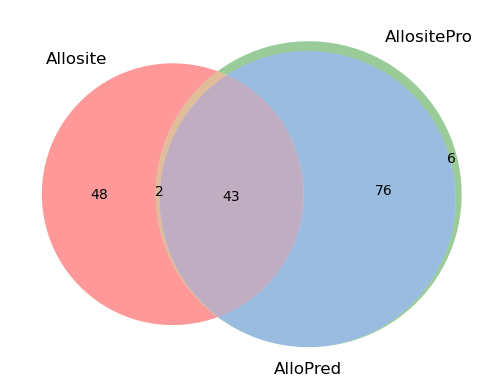

In [36]:
matplotlib_venn.venn3([allosite_uniprot_set, allositepro_uniprot_set, allopred_uniprot_set], ['Allosite', 'AllositePro', 'AlloPred']);

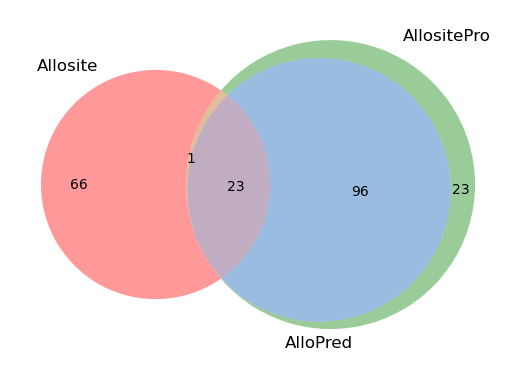

In [37]:
matplotlib_venn.venn3([allosite_pdb_set, allositepro_pdb_set, allopred_pdb_set], ['Allosite', 'AllositePro', 'AlloPred']);

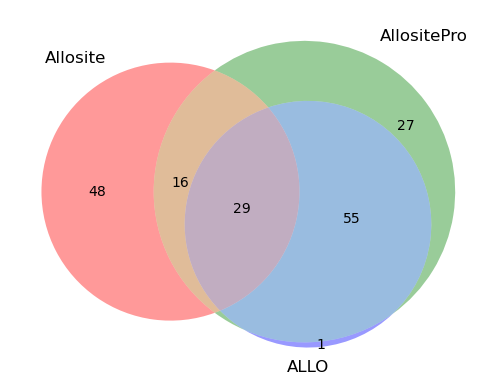

In [38]:
matplotlib_venn.venn3([allosite_uniprot_set, allositepro_uniprot_set, allo_uniprot_set], ['Allosite', 'AllositePro', 'ALLO']);

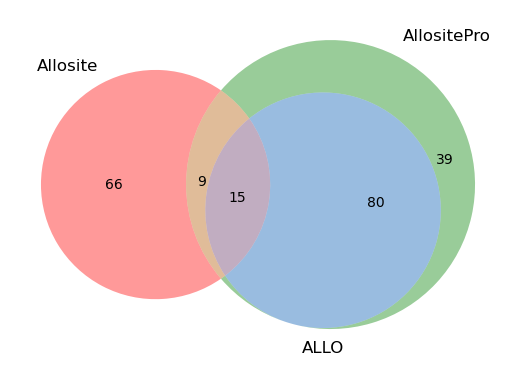

In [39]:
matplotlib_venn.venn3([allosite_pdb_set, allositepro_pdb_set, allo_pdb_set], ['Allosite', 'AllositePro', 'ALLO']);

The Allosite and AllositePro datasets are different and the AlloPred dataset is contained in AllositePro dataset.

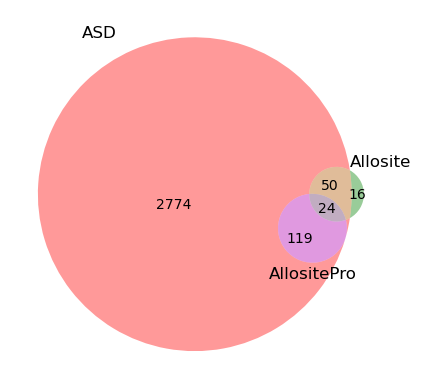

In [40]:
matplotlib_venn.venn3([asd_pdb_set, allosite_pdb_set, allositepro_pdb_set], ['ASD', 'Allosite', 'AllositePro']);

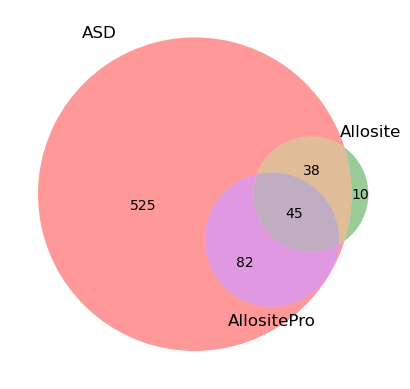

In [41]:
matplotlib_venn.venn3([asd_uniprot_set, allosite_uniprot_set, allositepro_uniprot_set], ['ASD', 'Allosite', 'AllositePro']);

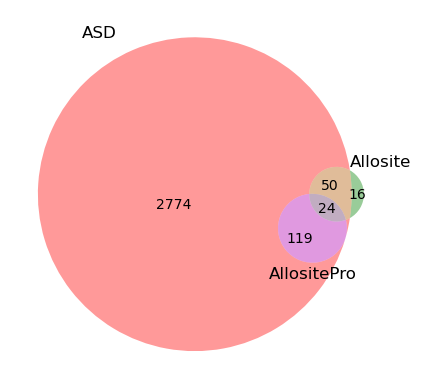

In [42]:
matplotlib_venn.venn3([asd_pdb_set, allosite_pdb_set, allositepro_pdb_set], ['ASD', 'Allosite', 'AllositePro']);

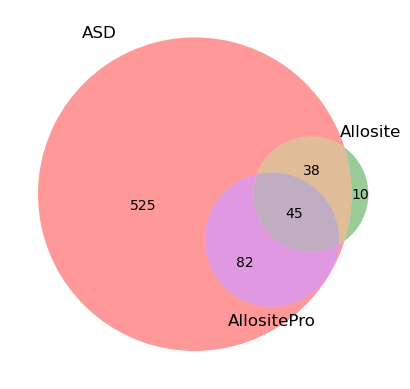

In [43]:
matplotlib_venn.venn3([asd_uniprot_set, allosite_uniprot_set, allositepro_uniprot_set], ['ASD', 'Allosite', 'AllositePro']);

In [44]:
df_allosite['asd90'] = True
df_allosite['allosite'] = True
df_allosite['passer_ensemble'] = True

df_allo['allo'] = True
df_combined = df_allosite.merge(df_allo, how='outer')

df_allositepro['allositepro'] = True
df_combined = df_combined.merge(df_allositepro, how='outer')

df_allopred['allopred'] = True
df_combined = df_combined.merge(df_allopred, how='outer')

df_passer['passer_automl'] = True
df_passer['passer_rank'] = True
df_combined = df_combined.merge(df_passer, how='outer')

df_combined.fillna('False', inplace=True)
df_combined[['pdb_id', 'uniprot_id', 'allo', 'allopred', 'allosite', 'allositepro', 'asd90', 'passer_ensemble', 'passer_automl', 'passer_rank']]

,pdb_id,uniprot_id,allo,allopred,allosite,allositepro,asd90,passer_ensemble,passer_automl,passer_rank
0,11BG,P00669,True,True,False,True,False,False,True,True
1,1AO0,P00497,False,False,True,False,True,True,False,False
2,1B86,P68871,True,True,False,True,False,False,False,False
3,1BJ4,P34896,False,False,False,False,False,False,True,True
4,1CE8,P00968,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...
361,4TPT,P53671,False,False,False,False,False,False,True,True
362,4TQC,P06730,False,False,False,False,False,False,True,True
363,4TVG,Q90EA1,False,False,False,False,False,False,True,True
364,4UUU,P35520,False,False,False,False,False,False,True,True


In [45]:
print('Number of Rows:             ', df_combined.shape[0])
print('Number of Unique PDB IDs:   ', df_combined['pdb_id'].nunique())
print('Number of Unique UniProt AC:', df_combined['uniprot_id'].nunique())

Number of Rows:              366
Number of Unique PDB IDs:    360
Number of Unique UniProt AC: 268


In [46]:
df_combined.to_csv('../output/Proteins_in_Training_Sets.csv', index=False)